## In this notebook:
- Using a pre-trained convnet to do feature extraction
    - Use ConvBase only for feature extraction, and use a separate machine learning classifier
    - Adding ```Dense``` layers to top of a frozen ConvBase, allowing us to leverage data augmentation 
- Fine-tuning a pre-trained convnet (Skipped, because I am tired now) 

### In previous notebook: 
- Training your own small convnets from scratch
- Using data augmentation to mitigate overfitting

In [1]:
from datetime import date
date.today()

datetime.date(2017, 12, 26)

In [2]:
author = "NirantK. https://github.com/NirantK/keras-practice"
print(author)

NirantK. https://github.com/NirantK/keras-practice


In [3]:
import keras
print('Keras Version:', keras.__version__)
import os
if os.name=='nt':
    print('We are on Windows')

Using TensorFlow backend.


Keras Version: 2.0.8


In [4]:
import os, shutil

In [5]:
pwd = os.getcwd()
print(pwd)

/home/nirant/keras-practice


Feature extraction
---
This consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.
![](https://dpzbhybb2pdcj.cloudfront.net/chollet/v-6/Figures/swapping_fc_classifier.png)

**Warning: The line below triggers a download. You need good speed Internet!**

In [6]:
# !wget http://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_matconvnet.tar.gz

In [7]:
# if you get CUDA_ERROR_OUT_OF_MEMORY, uncomment below, run and restart the notebook
# !sudo nvidia-modprobe -u -c=0

In [8]:
# !pip install keras_vggface

Feature Extraction
---
Pros: 
- Fast, and cheap
- Works on CPU

Cons: 
- Does not allow us to use data augmentation
    - Because we do feature extraction and classification in separate steps

In [12]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = os.path.join(pwd, 'data/ladies')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [13]:
from keras.engine import  Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace

# Convolution Features
vgg_features = VGGFace(include_top=False, input_shape=(150, 150, 3), pooling='max')

In [14]:
vgg_features.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 150, 150, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 150, 150, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 75, 75, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 75, 75, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 37, 37, 128)       0         
__________

In [15]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 1

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg_features.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [16]:
%time train_features, train_labels = extract_features(train_dir, 801)

Found 889 images belonging to 2 classes.
CPU times: user 5.35 s, sys: 668 ms, total: 6.02 s
Wall time: 5.68 s


In [17]:
%time validation_features, validation_labels = extract_features(validation_dir, 1000)
%time test_features, test_labels = extract_features(test_dir, 1000)

Found 300 images belonging to 2 classes.
CPU times: user 6.09 s, sys: 684 ms, total: 6.78 s
Wall time: 6.35 s
Found 200 images belonging to 2 classes.
CPU times: user 6 s, sys: 756 ms, total: 6.75 s
Wall time: 6.35 s


In [18]:
vgg_features.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 150, 150, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 150, 150, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 75, 75, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 75, 75, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 37, 37, 128)       0         
__________

In [19]:
train_features = np.reshape(train_features, (801, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [20]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [25]:
%time history = model.fit(train_features, train_labels, epochs=30, batch_size=20, \
                          validation_data=(validation_features, validation_labels))

Train on 801 samples, validate on 1000 samples
Epoch 1/30
801/801 [==============================] - 0s - loss: 0.4793 - acc: 0.7828 - val_loss: 0.4683 - val_acc: 0.7810
Epoch 2/30
801/801 [==============================] - 0s - loss: 0.4614 - acc: 0.8015 - val_loss: 0.4453 - val_acc: 0.7880
Epoch 3/30
801/801 [==============================] - 0s - loss: 0.4583 - acc: 0.8115 - val_loss: 0.4485 - val_acc: 0.7780
Epoch 4/30
801/801 [==============================] - 0s - loss: 0.4631 - acc: 0.7978 - val_loss: 0.4597 - val_acc: 0.7850
Epoch 5/30
801/801 [==============================] - 0s - loss: 0.4505 - acc: 0.8090 - val_loss: 0.4417 - val_acc: 0.8000
Epoch 6/30
801/801 [==============================] - 0s - loss: 0.4521 - acc: 0.8290 - val_loss: 0.4634 - val_acc: 0.7820
Epoch 7/30
801/801 [==============================] - 0s - loss: 0.4508 - acc: 0.8090 - val_loss: 0.4380 - val_acc: 0.8000
Epoch 8/30
801/801 [==============================] - 0s - loss: 0.4489 - acc: 0.8102 - val_

In [26]:
model.save('emma_faces_feature_extraction.h5')

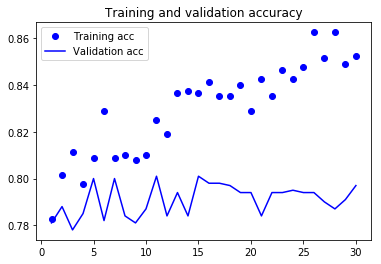

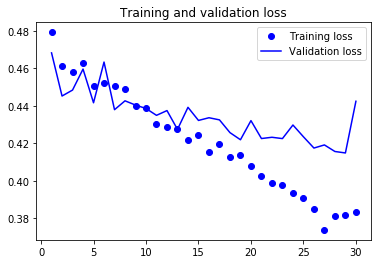

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Extending the ConvBase Model!
---
Pros: 
- Better performance (accuracy)
- Better Generalization (less overfitting) 
    - Because we can use data augmentation
    
Cons:
- Expensive compute

**Warning: Do not attempt this without a GPU. Your Python process can/will crash after a few hours**

In [28]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(vgg_features)
# model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_vgg16 (Model)        (None, 512)               14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


### Freezing ConvBase model: VGG16

Freezing means we do not update the layer weights in those particular layers. This is important for our present application.

In [30]:
print('This is the number of trainable weights '
         'before freezing the base:', len(model.trainable_weights))
vgg_features.trainable = False
print('This is the number of trainable weights '
          'after freezing the base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the base: 30
This is the number of trainable weights after freezing the base: 4


In [31]:
model.summary()
# compare the Trainable Params value from the previous model summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_vgg16 (Model)        (None, 512)               14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 14,846,273
Trainable params: 131,585
Non-trainable params: 14,714,688
_________________________________________________________________


In [32]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50)

Found 889 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Epoch 1/10
100/100 [==============================] - 21s - loss: 0.6496 - acc: 0.6107 - val_loss: 0.5174 - val_acc: 0.7430
Epoch 2/10
100/100 [==============================] - 19s - loss: 0.5749 - acc: 0.6887 - val_loss: 0.4224 - val_acc: 0.8010
Epoch 3/10
100/100 [==============================] - 19s - loss: 0.4969 - acc: 0.7516 - val_loss: 0.2879 - val_acc: 0.8910
Epoch 4/10
100/100 [==============================] - 19s - loss: 0.4515 - acc: 0.7757 - val_loss: 0.3190 - val_acc: 0.8730
Epoch 5/10
100/100 [==============================] - 19s - loss: 0.4002 - acc: 0.8087 - val_loss: 0.4152 - val_acc: 0.8380
Epoch 6/10
100/100 [==============================] - 19s - loss: 0.3925 - acc: 0.8146 - val_loss: 0.2525 - val_acc: 0.9190
Epoch 7/10
100/100 [==============================] - 19s - loss: 0.3502 - acc: 0.8343 - val_loss: 0.3542 - val_acc: 0.8470
Epoch 8/10
100/100 [==============================

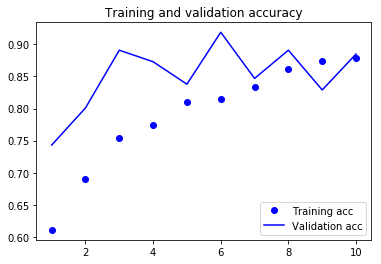

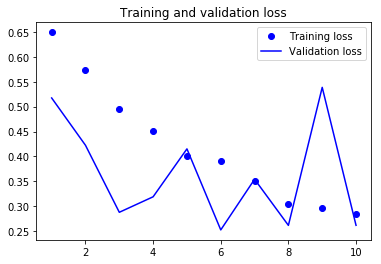

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
# just for reference, let's calculate the test accuracy
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

%time test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 200 images belonging to 2 classes.
CPU times: user 3.28 s, sys: 316 ms, total: 3.59 s
Wall time: 2.61 s
test acc: 0.874999992847
